# 4. Evaluation Metrics for Classification

Course info: https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp

Note: it is good practice to clear the outputs before pushing, however, here the complete notebook is pushed as it is a small notebook and the goal is to see the answers to the questions.

In [16]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [17]:
# !pip install tqdm

In [18]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
    
path = "/home/mmc/Desktop/DataTalks/W4/"
df_original = pd.read_csv(path + "CreditScoring.csv")

#### Preparation

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started


In [19]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Some of the features are encoded as numbers. Use the following code to de-code them:

In [20]:
status_values = {     # <--- Status will become our target 
    1: 'ok',
    2: 'default',
    0: 'unk'
}

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

Prepare the numerical variables:

In [21]:
# df[df.values == 99999999] # there are many values like that, like row 29 let us replace them by 0
for i in ['income', 'assets', 'debt']:
    df[i] = df[i].replace(to_replace=99999999, value=0)
# df.iloc[29]

In [22]:
# Remove clients with unknown default status
df = df[df.status != 'unk'].reset_index(drop=True)

In [23]:
# Create the target variable
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [24]:
df

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,rent,60,39,married,no,fixed,69,92,0,0,900,1020,1
4450,22,owner,60,46,married,no,fixed,60,75,3000,600,950,1263,0
4451,0,owner,24,37,married,no,partime,60,90,3500,0,500,963,1
4452,0,rent,48,23,single,no,freelance,49,140,0,0,550,550,0


What are the categorical variables? What are the numerical?

In [25]:
df.dtypes

seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
default       int64
dtype: object

In [26]:
numerical = ['seniority', 'time', 'age','expenses', 'income', 'assets', 'debt', 'amount', 'price']
categorical = [ 'home', 'marital', 'records', 'job']

#### Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [27]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the "default" variable
    Use the training dataset for that
    
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.


In [28]:
# Just imagine that your model's output is just that feature: target is true values and feature is predictions
for col in numerical:       
    auc = roc_auc_score(y_train, df_train[col]) #df_train['seniority'])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print(col,auc)

seniority 0.7093778624491943
time 0.5608662489595051
age 0.5732933272499939
expenses 0.5009184217217011
income 0.682006666132633
assets 0.6486042567122802
debt 0.5047829675783548
amount 0.5910773431595518
price 0.5043329862114843


The feauture "seniority" has the highest accuracy.

#### Training the model

From now on, use these columns only: ['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [29]:
select_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

# OHE with DictVec
dv = DictVectorizer(sparse=False)

train_dict = df_train[select_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[select_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

#default_decision = (y_pred >= 0.5)
#(y_val == default_decision).mean()

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits).

In [30]:
auc = roc_auc_score(y_val, y_pred)
auc.round(3)

0.812

## Question 3

Now let's compute precision and recall for our model.

+ Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
+ For each threshold, compute precision and recall
+ Plot them

Where precision and recall meet? 

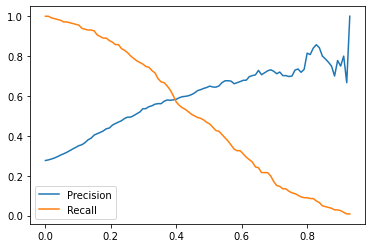

In [31]:
def precision_recall(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0., 0.93, 101) #(0., 1., 101) # range of thresholds shortened to avoid diving by 0

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum().round(3)
        tn = (predict_negative & actual_negative).sum().round(3)

        fp = (predict_positive & actual_negative).sum().round(3)
        fn = (predict_negative & actual_positive).sum().round(3)
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)

        scores.append((t, p, r))
        
        columns = ['threshold', 'precision', 'recall']
        df_PandR = pd.DataFrame(scores, columns=columns)

    return df_PandR

df_PandR = precision_recall(y_val,y_pred)

plt.plot(df_PandR.threshold, df_PandR.precision, label='Precision')
plt.plot(df_PandR.threshold, df_PandR.recall, label='Recall')
plt.legend()

Precision and recall meet at about 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1: F1 = 2 * P * R / (P + R)

Where P is precision and R is recall. 
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [32]:
def precision_recall_F1(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0., 0.93, 101) #(0., 1., 101) # range of thresholds shortened to avoid diving by 0

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum().round(3)
        tn = (predict_negative & actual_negative).sum().round(3)

        fp = (predict_positive & actual_negative).sum().round(3)
        fn = (predict_negative & actual_positive).sum().round(3)
        
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        F1 = 2 * p * r / (p + r)

        scores.append((t, p, r, F1))
        
        columns = ['threshold', 'precision', 'recall', 'F1']
        df_PandRandF1 = pd.DataFrame(scores, columns=columns)

    return df_PandRandF1

df_PandRandF1 = precision_recall_F1(y_val, y_pred)
df_PandRandF1

,threshold,precision,recall,F1
0,0.0000,0.276094,1.000000,0.432718
1,0.0093,0.279228,1.000000,0.436557
2,0.0186,0.283721,0.991870,0.441230
3,0.0279,0.288942,0.987805,0.447102
4,0.0372,0.295844,0.983740,0.454887
...,...,...,...,...
96,0.8928,0.777778,0.028455,0.054902
97,0.9021,0.750000,0.024390,0.047244
98,0.9114,0.800000,0.016260,0.031873
99,0.9207,0.666667,0.008130,0.016064


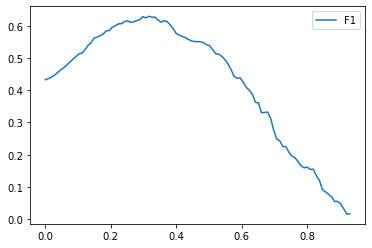

In [33]:
plt.plot(df_PandR.threshold, df_PandRandF1.F1, label='F1')
plt.legend()

In [34]:
df_PandRandF1.iloc[df_PandRandF1.F1.idxmax()].round(2)

threshold    0.32
precision    0.55
recall       0.74
F1           0.63
Name: 34, dtype: float64

F1 is maximal at threshold 0.3.

## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds: KFold(n_splits=5, shuffle=True, random_state=1)

+ Iterate over different folds of df_full_train
+ Split the data into train and validation
+ Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
+ Use AUC to evaluate the model on validation

In [35]:
# We use cross-validation: to evaluate the same model on different data subsets and get mean and std of the prediction

def train(df_train, y_train, C=1.0):
    dicts = df_train[select_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear',C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[select_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [36]:
n = 5

C = 1.0

kfold = KFold(n_splits=n, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    y_val = df_val.default.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
        
print(scores)

[0.8256212256212256, 0.8254077031563474, 0.789298525308888, 0.8153421373265731, 0.8054696294614563]


In [37]:
print("mean of accuracy scores:", np.mean(scores).round(3))
print("std of accuracy scores:", np.std(scores).round(3))

mean of accuracy scores: 0.812
std of accuracy scores: 0.014


# Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

+ Iterate over the following C values: [0.01, 0.1, 1, 10]
+ Initialize KFold with the same parameters as previously
+ Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
+ Compute the mean score as well as the std (round the mean and std to 3 decimal 

In [38]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    kfold = KFold(n_splits=n, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores).round(3), np.std(scores).round(3)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.809 +- 0.013
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


Which C leads to the best mean score? If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

Solution: C=10 leads to the best mean score.